In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import torchvision.datasets as datasets
from tqdm import tqdm
import os
import timm
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import DataLoader


/home/xy_ubuntu/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset: MNIST

In [2]:

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

train_X = np.array([np.array(x[0]) for x in trainset])
train_Y = np.array([np.array(x[1]) for x in trainset])
train_size = len(train_X)
test_X = np.array([np.array(x[0]) for x in testset])
test_Y = np.array([np.array(x[1]) for x in testset])
test_size = len(test_X)

train_x, train_y, test_x, test_y = np.copy(train_X.reshape((train_size,-1))), np.copy(train_Y), np.copy(test_X.reshape((test_size,-1))), np.copy(test_Y)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

t095=2.132
Iteration=5
Ms = [10, 100, 1000, 5000, 10000]

(60000, 784) (60000,) (10000, 784) (10000,)


In [8]:
def random_selection(train_x, train_y, M, seed):
    np.random.seed(seed=seed)
    selected_indexes = np.random.choice(len(train_x), M, replace=False)
    train_x = train_x[selected_indexes]
    train_y = train_y[selected_indexes]
    return train_x, train_y

def kmean_selection(train_x, train_y, M, seed):
    new_train_x = []
    new_train_y = []
    for i in range(10):
        sub_train_x = train_x[train_y==i]
        kmeans = KMeans(n_clusters = M//10, random_state=seed).fit(sub_train_x)
        new_train_x.extend(kmeans.cluster_centers_)
        new_train_y.extend([i]*(M//10))
    return new_train_x, new_train_y

def pipeline(train_X, train_Y, test_X, test_Y, M, select_func, t, Iteration, seeds=list(range(5))):
    accs = []
    for iter, seed in zip(range(Iteration), seeds):
        train_x, train_y, test_x, test_y = np.copy(train_X), np.copy(train_Y), np.copy(test_X), np.copy(test_Y)
        train_x, train_y = select_func(train_x, train_y, M, seed)
        classifier = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
        classifier.fit(train_x, train_y)
        classifier.score(test_x,test_y)
        acc = classifier.score(test_x, test_y)
        accs.append(acc)
        print(f"Iter: {iter}  Acc: {acc}")
        classifier = None
    
    accs = np.array(accs)
    mean = accs.mean()
    std = np.std(accs)
    std_sample = np.std(accs, ddof=1)
    interval = (mean-t*std_sample/np.sqrt(len(accs)),mean+t*std_sample/np.sqrt(len(accs)))
    
    return accs, mean, std, std_sample, interval

def load_embeddings(path='data'):
    return np.load(os.path.join(path, "train_x.npy")), np.load(os.path.join(path, "train_y.npy")), np.load(os.path.join(path, "test_x.npy")), np.load(os.path.join(path, "test_y.npy"))

def embedded_pipeline(M, select_func, t, Iteration, seeds=list(range(5)), path="./data"):
    train_X, train_Y, test_X, test_Y = load_embeddings(path)
    accs = []
    for iter, seed in zip(range(Iteration), seeds):
        train_x, train_y, test_x, test_y = np.copy(train_X), np.copy(train_Y), np.copy(test_X), np.copy(test_Y)
        train_x, train_y = select_func(train_x, train_y, M, seed)
        classifier = KNeighborsClassifier(n_neighbors=1, algorithm="brute")
        classifier.fit(train_x, train_y)
        classifier.score(test_x,test_y)
        acc = classifier.score(test_x, test_y)
        accs.append(acc)
        print(f"Iter: {iter}  Acc: {acc}")
        classifier = None
    
    accs = np.array(accs)
    mean = accs.mean()
    std = np.std(accs)
    std_sample = np.std(accs, ddof=1)
    interval = (mean-t*std_sample/np.sqrt(len(accs)),mean+t*std_sample/np.sqrt(len(accs)))
    
    return accs, mean, std, std_sample, interval

In [4]:
# Random select M from the training set
for M in [60000]:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = pipeline(train_x, train_y, test_x, test_y, M, select_func=random_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42])

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 60000
Iter: 0  Acc: 0.9691
Iter: 1  Acc: 0.9691
Iter: 2  Acc: 0.9691
Iter: 3  Acc: 0.9691
Iter: 4  Acc: 0.9691
Accuracies: [0.9691 0.9691 0.9691 0.9691 0.9691]
Mean: 0.96910
Standard Deviation: 1.1102e-16
Confidence Interval: (0.96910  0.96910)



In [2]:
Ms = [10, 100, 1000, 5000, 10000]

## Baseline: Random selection

In [4]:
# Random select M from the training set
for M in Ms:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = pipeline(train_x, train_y, test_x, test_y, M, select_func=random_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42])

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 10
Iter: 0  Acc: 0.2769
Iter: 1  Acc: 0.3296
Iter: 2  Acc: 0.4053
Iter: 3  Acc: 0.3796
Iter: 4  Acc: 0.3074
Accuracies: [0.2769 0.3296 0.4053 0.3796 0.3074]
Mean: 0.33976
Standard Deviation: 0.046871
Confidence Interval: (0.28980  0.38972)

M: 100
Iter: 0  Acc: 0.7273
Iter: 1  Acc: 0.7054
Iter: 2  Acc: 0.7291
Iter: 3  Acc: 0.7126
Iter: 4  Acc: 0.722
Accuracies: [0.7273 0.7054 0.7291 0.7126 0.722 ]
Mean: 0.71928
Standard Deviation: 0.0090048
Confidence Interval: (0.70968  0.72888)

M: 1000
Iter: 0  Acc: 0.8903
Iter: 1  Acc: 0.8849
Iter: 2  Acc: 0.885
Iter: 3  Acc: 0.8848
Iter: 4  Acc: 0.8874
Accuracies: [0.8903 0.8849 0.885  0.8848 0.8874]
Mean: 0.88648
Standard Deviation: 0.0021423
Confidence Interval: (0.88420  0.88876)

M: 5000
Iter: 0  Acc: 0.9385
Iter: 1  Acc: 0.9373
Iter: 2  Acc: 0.9337
Iter: 3  Acc: 0.9317
Iter: 4  Acc: 0.9357
Accuracies: [0.9385 0.9373 0.9337 0.9317 0.9357]
Mean: 0.93538
Standard Deviation: 0.0024449
Confidence Interval: (0.93277  0.93799)

M: 10000
Iter: 0  

## Baseline: KMeans Selection

In [5]:
for M in Ms:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = pipeline(train_x, train_y, test_x, test_y, M, select_func=kmean_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42])

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 10
Iter: 0  Acc: 0.8203
Iter: 1  Acc: 0.8203
Iter: 2  Acc: 0.8203
Iter: 3  Acc: 0.8203
Iter: 4  Acc: 0.8203
Accuracies: [0.8203 0.8203 0.8203 0.8203 0.8203]
Mean: 0.82030
Standard Deviation: 1.1102e-16
Confidence Interval: (0.82030  0.82030)

M: 100
Iter: 0  Acc: 0.9226
Iter: 1  Acc: 0.9281
Iter: 2  Acc: 0.924
Iter: 3  Acc: 0.9232
Iter: 4  Acc: 0.9223
Accuracies: [0.9226 0.9281 0.924  0.9232 0.9223]
Mean: 0.92404
Standard Deviation: 0.0021115
Confidence Interval: (0.92179  0.92629)

M: 1000
Iter: 0  Acc: 0.9583
Iter: 1  Acc: 0.9574
Iter: 2  Acc: 0.9584
Iter: 3  Acc: 0.9581
Iter: 4  Acc: 0.9579
Accuracies: [0.9583 0.9574 0.9584 0.9581 0.9579]
Mean: 0.95802
Standard Deviation: 0.0003544
Confidence Interval: (0.95764  0.95840)

M: 5000
Iter: 0  Acc: 0.9682
Iter: 1  Acc: 0.9692
Iter: 2  Acc: 0.9688
Iter: 3  Acc: 0.9693
Iter: 4  Acc: 0.9694
Accuracies: [0.9682 0.9692 0.9688 0.9693 0.9694]
Mean: 0.96898
Standard Deviation: 0.00044
Confidence Interval: (0.96851  0.96945)

M: 10000
Iter: 0 

# Latent Methods

## ResNet Embedder (Pretrained on ImageNet1K)

In [10]:
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=False)
testloader = DataLoader(dataset=trainset, batch_size=64, shuffle=False)

resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Identity()
resnet = resnet.to("cuda")

new_x = []
new_y = []
with torch.no_grad():
    for x, y in tqdm(trainloader):
        x = x.to("cuda")
        x = resnet(x)
        x = x.cpu().numpy()
        new_x.extend(x)
        new_y.extend(y)
    
new_x = np.array(new_x)
np.save("data/train_x.npz", new_x)
new_y = np.array(new_y)
np.save("data/train_y.npz", new_y)

new_x = []
new_y = []
with torch.no_grad():
    for x, y in tqdm(testloader):
        x = x.to("cuda")
        x = resnet(x)
        x = x.cpu().numpy()
        new_x.extend(x)
        new_y.extend(y)
    
new_x = np.array(new_x)
np.save("data/test_x.npz", new_x)
new_y = np.array(new_y)
np.save("data/test_y.npz", new_y)

/home/xy_ubuntu/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xy_ubuntu/anaconda3/envs/pytorch-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 938/938 [02:33<00:00,  6.11it/s]


In [20]:
for M in Ms:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = embedded_pipeline(M, select_func=random_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42],path="data/imagenet/")

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 10
Iter: 0  Acc: 0.32736666666666664
Iter: 1  Acc: 0.27573333333333333
Iter: 2  Acc: 0.39098333333333335
Iter: 3  Acc: 0.4154
Iter: 4  Acc: 0.3262333333333333
Accuracies: [0.32736667 0.27573333 0.39098333 0.4154     0.32623333]
Mean: 0.34714
Standard Deviation: 0.050017
Confidence Interval: (0.29382  0.40046)

M: 100
Iter: 0  Acc: 0.6605
Iter: 1  Acc: 0.6428333333333334
Iter: 2  Acc: 0.6619666666666667
Iter: 3  Acc: 0.6345333333333333
Iter: 4  Acc: 0.6404833333333333
Accuracies: [0.6605     0.64283333 0.66196667 0.63453333 0.64048333]
Mean: 0.64806
Standard Deviation: 0.011098
Confidence Interval: (0.63623  0.65989)

M: 1000
Iter: 0  Acc: 0.8139
Iter: 1  Acc: 0.8235833333333333
Iter: 2  Acc: 0.82825
Iter: 3  Acc: 0.82565
Iter: 4  Acc: 0.8193666666666667
Accuracies: [0.8139     0.82358333 0.82825    0.82565    0.81936667]
Mean: 0.82215
Standard Deviation: 0.0050463
Confidence Interval: (0.81677  0.82753)

M: 5000
Iter: 0  Acc: 0.8911
Iter: 1  Acc: 0.8933666666666666
Iter: 2  Acc: 0.8

In [21]:
for M in Ms:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = embedded_pipeline(M, select_func=kmean_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42],path="data/imagenet/")

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 10
Iter: 0  Acc: 0.8743833333333333
Iter: 1  Acc: 0.8743833333333333
Iter: 2  Acc: 0.8743833333333333
Iter: 3  Acc: 0.8743833333333333
Iter: 4  Acc: 0.8743833333333333
Accuracies: [0.87438333 0.87438333 0.87438333 0.87438333 0.87438333]
Mean: 0.87438
Standard Deviation: 0.0
Confidence Interval: (0.87438  0.87438)

M: 100
Iter: 0  Acc: 0.92625
Iter: 1  Acc: 0.9241166666666667
Iter: 2  Acc: 0.9245
Iter: 3  Acc: 0.9267
Iter: 4  Acc: 0.9247166666666666
Accuracies: [0.92625    0.92411667 0.9245     0.9267     0.92471667]
Mean: 0.92526
Standard Deviation: 0.0010231
Confidence Interval: (0.92417  0.92635)

M: 1000
Iter: 0  Acc: 0.96785
Iter: 1  Acc: 0.9675333333333334
Iter: 2  Acc: 0.9674333333333334
Iter: 3  Acc: 0.9680166666666666
Iter: 4  Acc: 0.9678666666666667
Accuracies: [0.96785    0.96753333 0.96743333 0.96801667 0.96786667]
Mean: 0.96774
Standard Deviation: 0.00021975
Confidence Interval: (0.96751  0.96797)

M: 5000
Iter: 0  Acc: 0.99065
Iter: 1  Acc: 0.9910166666666667
Iter: 2  A

# ResNet18 Embedder (pretrained on MNIST)

In [15]:
resnet = timm.create_model("resnet18", pretrained=False, num_classes=10)
resnet.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.load_state_dict(
  torch.hub.load_state_dict_from_url(
    "https://huggingface.co/gpcarl123/resnet18_mnist/resolve/main/resnet18_mnist.pth",
    map_location="cpu",
    file_name="resnet18_mnist.pth",
  )
)
resnet.fc=nn.Identity()
preprocessor = torchvision.transforms.Normalize((0.1307,), (0.3081,))
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(dataset=trainset, batch_size=64, shuffle=False)
testloader = DataLoader(dataset=trainset, batch_size=64, shuffle=False)

resnet = resnet.to("cuda")

new_x = []
new_y = []
with torch.no_grad():
    for x, y in tqdm(trainloader):
        x = x.to("cuda")
        x = resnet(preprocessor(x))
        x = x.cpu().numpy()
        new_x.extend(x)
        new_y.extend(y)
    
new_x = np.array(new_x)
np.save("data/train_x", new_x)
new_y = np.array(new_y)
np.save("data/train_y", new_y)

new_x = []
new_y = []
with torch.no_grad():
    for x, y in tqdm(testloader):
        x = x.to("cuda")
        x = resnet(x)
        x = x.cpu().numpy()
        new_x.extend(x)
        new_y.extend(y)
    
new_x = np.array(new_x)
np.save("data/test_x", new_x)
new_y = np.array(new_y)
np.save("data/test_y", new_y)

100%|██████████| 938/938 [00:05<00:00, 161.79it/s]


In [18]:
for M in Ms:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = embedded_pipeline(M, select_func=random_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42])

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 10
Iter: 0  Acc: 0.56395
Iter: 1  Acc: 0.6872333333333334
Iter: 2  Acc: 0.6950833333333334
Iter: 3  Acc: 0.79325
Iter: 4  Acc: 0.5870166666666666
Accuracies: [0.56395    0.68723333 0.69508333 0.79325    0.58701667]
Mean: 0.66531
Standard Deviation: 0.082631
Confidence Interval: (0.57722  0.75339)

M: 100
Iter: 0  Acc: 0.9882333333333333
Iter: 1  Acc: 0.9898833333333333
Iter: 2  Acc: 0.9891833333333333
Iter: 3  Acc: 0.9877
Iter: 4  Acc: 0.9903
Accuracies: [0.98823333 0.98988333 0.98918333 0.9877     0.9903    ]
Mean: 0.98906
Standard Deviation: 0.00097608
Confidence Interval: (0.98802  0.99010)

M: 1000
Iter: 0  Acc: 0.9892
Iter: 1  Acc: 0.9909666666666667
Iter: 2  Acc: 0.9916
Iter: 3  Acc: 0.9916833333333334
Iter: 4  Acc: 0.9919666666666667
Accuracies: [0.9892     0.99096667 0.9916     0.99168333 0.99196667]
Mean: 0.99108
Standard Deviation: 0.00099677
Confidence Interval: (0.99002  0.99215)

M: 5000
Iter: 0  Acc: 0.9919333333333333
Iter: 1  Acc: 0.99245
Iter: 2  Acc: 0.99245
Iter: 

In [19]:
for M in Ms:
    print(f"M: {M}")
    accs, mean, std, std_sample, interval = embedded_pipeline(M, select_func=kmean_selection, t=t095, Iteration=Iteration, seeds=[17, 26, 58, 96, 42])

    print(f"Accuracies: {accs}")  
    print("Mean: {:.5f}".format(mean))
    print("Standard Deviation: {:.5}".format(std))
    print("Confidence Interval: ({:.5f}  {:.5f})".format(interval[0], interval[1]))
    print()

M: 10
Iter: 0  Acc: 0.9910833333333333
Iter: 1  Acc: 0.9910833333333333
Iter: 2  Acc: 0.9910833333333333
Iter: 3  Acc: 0.9910833333333333
Iter: 4  Acc: 0.9910833333333333
Accuracies: [0.99108333 0.99108333 0.99108333 0.99108333 0.99108333]
Mean: 0.99108
Standard Deviation: 0.0
Confidence Interval: (0.99108  0.99108)

M: 100
Iter: 0  Acc: 0.9944
Iter: 1  Acc: 0.9941166666666666
Iter: 2  Acc: 0.9941333333333333
Iter: 3  Acc: 0.9942333333333333
Iter: 4  Acc: 0.9941333333333333
Accuracies: [0.9944     0.99411667 0.99413333 0.99423333 0.99413333]
Mean: 0.99420
Standard Deviation: 0.00010667
Confidence Interval: (0.99409  0.99432)

M: 1000
Iter: 0  Acc: 0.9940333333333333
Iter: 1  Acc: 0.9944166666666666
Iter: 2  Acc: 0.9943666666666666
Iter: 3  Acc: 0.9940333333333333
Iter: 4  Acc: 0.99385
Accuracies: [0.99403333 0.99441667 0.99436667 0.99403333 0.99385   ]
Mean: 0.99414
Standard Deviation: 0.00021669
Confidence Interval: (0.99391  0.99437)

M: 5000
Iter: 0  Acc: 0.9976
Iter: 1  Acc: 0.9971

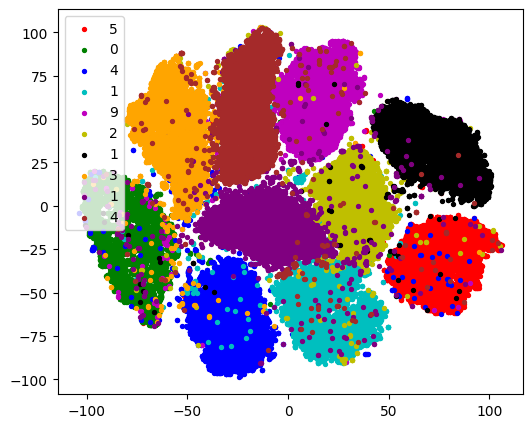

In [6]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

X = np.array([np.array(x[0]) for x in trainset]).reshape((60000, -1))
y = np.array([np.array(x[1]) for x in trainset])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

# Plot the result of t-SNE
target_ids = range(10)

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=str(y[i]), s=8)
plt.legend()
plt.savefig("tsne1.pdf")
plt.show()

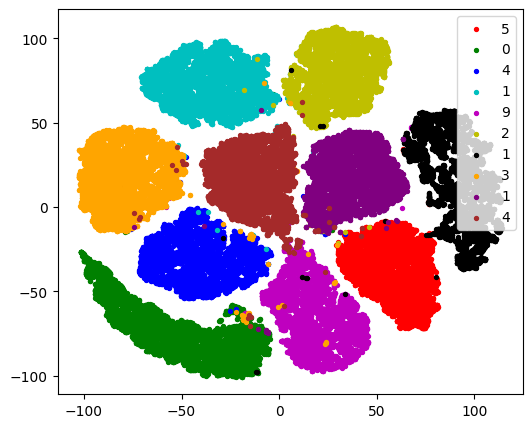

In [9]:
X, y, _, _ = load_embeddings("./data")
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

# Plot the result of t-SNE
target_ids = range(10)

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=str(y[i]), s=8)
plt.legend()
plt.savefig("tsne2.pdf")
plt.show()

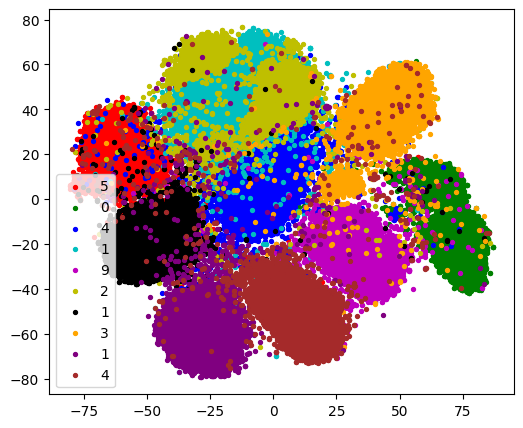

In [10]:
X, y, _, _ = load_embeddings("./data/imagenet/")
# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_2d = tsne.fit_transform(X)

# Plot the result of t-SNE
target_ids = range(10)

plt.figure(figsize=(6, 5))
colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown'
for i, c in zip(target_ids, colors):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=c, label=str(y[i]), s=8)
plt.legend()
plt.savefig("tsne2.pdf")
plt.show()